In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
from glob import glob
import numpy as np
import time
import music21
from music21 import converter, instrument, note, chord, stream

epochs= 50
maxv = 104 # High Velocity Value
minv = 22 # Low Velocity Value
PATH = '/content/drive/MyDrive/Velocity/'
modelname = time.strftime('%Y-%m-%d', time.localtime(time.time()))+f"-weights.kbmodel2-6_epoch{epochs}.hdf5"

In [11]:
def make_Data():
    ''' 
    Load dataset
    '''
    with open(PATH+"Data3.pickle",'rb') as file : 
      notes = pickle.load(file)
    return notes

In [7]:
def prepare_sequences(notes):
    '''
    Create input data and output data
    '''
    network_input = []
    network_output = []
    maxv =  max([_[0] for _ in notes])
    minv = min([_[0] for _ in notes])

    for i in notes:
        network_input.append(i[:-1])
        network_output.append(i[-1])
        # data normalization
        network_input[-1][0] = (network_input[-1][0]-minv) / (maxv-minv)
    n_patterns = len(network_input)

    network_input = np.reshape(network_input, (n_patterns, 3,1))
    network_output = np.array(network_output)
    return (network_input, network_output)


In [8]:
def create_network(network_in):
    """
    Create the model architecture
    """

    learning_rate = 0.005
    model = Sequential()
    model.add(LSTM(128, input_shape=network_in.shape[1:]))

    model.add(Dense(128))
    model.add(Activation('softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(loss=loss,loss_weights=0.05 ,optimizer=optimizer)

    model.summary()
    return model

In [9]:
def train(model, network_input, network_output, epochs):
    """
    Train the neural network
    """
    filepath = PATH+modelname
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    return model.fit(network_input, network_output, epochs=epochs, batch_size=32, callbacks=[checkpoint])


In [13]:
notes = make_Data()
network_in, network_out = prepare_sequences(notes)
model = create_network(network_in)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
Total params: 83,072
Trainable params: 83,072
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = train(model, network_in, network_out, epochs)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


339/339 [==============================] - 9s 4ms/step - loss: 0.2158
Epoch 2/50
339/339 [==============================] - 2s 5ms/step - loss: 0.2138
Epoch 3/50
339/339 [==============================] - 2s 5ms/step - loss: 0.2133
Epoch 4/50
339/339 [==============================] - 2s 5ms/step - loss: 0.2131
Epoch 5/50
339/339 [==============================] - 1s 4ms/step - loss: 0.2129
Epoch 6/50
339/339 [==============================] - 1s 4ms/step - loss: 0.2127
Epoch 7/50
339/339 [==============================] - 1s 4ms/step - loss: 0.2125
Epoch 8/50
339/339 [==============================] - 2s 6ms/step - loss: 0.2123
Epoch 9/50
339/339 [==============================] - 1s 4ms/step - loss: 0.2119
Epoch 10/50
339/339 [==============================] - 1s 4ms/step - loss: 0.2116
Epoch 11/50
339/339 [==============================] - 3s 7ms/step - loss: 0.2112
Epoch 12/50
339/339 [==============================] - 2s 5ms/step - loss: 0.2108
Epoch 13/50
339/339 [===============

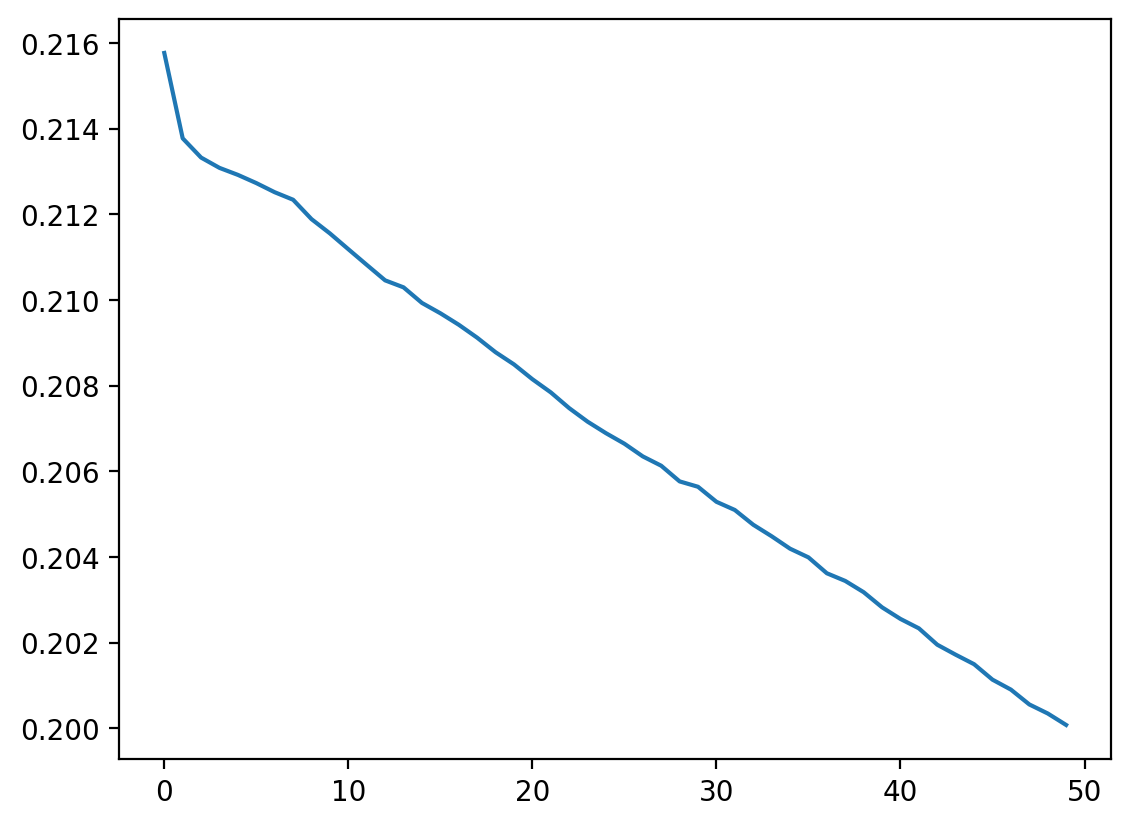

In [15]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [16]:
def generate(name):
    """ Velocity Prediction """

    # Get data to predict
    with open(PATH + name+'.pickle', 'rb') as filepath:
        notes = pickle.load(filepath)

    print('Initiating music generation process.......')

    # Creating data input
    n_patterns = len(notes)
    network_input = []
    for idx,_ in enumerate(notes) :
        network_input.append(_[:])
        network_input[-1][0] = (network_input[-1][0] - minv) / (maxv - minv)

    network_input = np.reshape(network_input, (n_patterns, 3,1))
    model = create_network(network_input)
    print('Loading Model weights.....')
    model.load_weights(PATH+modelname)
    print('Model Loaded')

    # Velocity Prediction
    prediction_output = generate_notes(model, network_input)
    create_midi(i,notes,prediction_output)

In [17]:

def generate_notes(model, network_input):
    """ Velocity Prediction with Pitch, Offset and Duration """
    prediction_output = []

    #  0-127 Velocity Prediction
    for note_index in range(network_input.shape[0]):
        prediction_input = np.reshape(network_input[note_index], (1, len(network_input[note_index]), 1))
        prediction = model.predict(prediction_input, verbose=0)
        prediction_output.append(int(np.where(prediction==np.max(prediction))[1]))

    return prediction_output

In [18]:
def create_midi(name,network_input,prediction_output):
    """ Put the predicted velocity value into the actual MIDI and save it. """
    offset = 0
    output_notes = []

    for idx,pattern in enumerate(network_input):
        new_note = note.Note(pattern[0])
        new_note.volume.velocity =  prediction_output[idx]
        new_note.offset = pattern[1]
        new_note.quarterLength=pattern[2]
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    midi_stream = stream.Stream(output_notes)

    print('Saving Output file as midi....')

    midi_stream.write('midi', fp='/content/drive/MyDrive/output/'+name+'.mid')

In [20]:
midi_names = ['80-46-1', '81-67-1', '81-67-2', '82-31-1', '83-18-1', '84-35-1', '84-35-2', '85-55-1', '86-30-1', '87-38-1', '88-36-1', '88-36-2', '89-35-1', '90-43-1']
for i in midi_names : 
  generate(i)

Initiating music generation process.......
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
Total params: 83,072
Trainable params: 83,072
Non-trainable params: 0
_________________________________________________________________
Loading Model weights.....
Model Loaded
Saving Output file as midi....
Initiating music generation process.......
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ls